# Calc Geostrophic Velocity Between Stations

- EPIC tool on iris3?
- wrt bottom (or common deepest value) vs wrt to surface

- seawater vs gsw

In [76]:
import pandas as pd
import numpy as np
import seawater
import gsw

In [100]:
dfo = pd.read_csv('~/Downloads/CTD_aq1201_final_6f37_d0e5_e2c9.csv')

In [199]:
dfg = dfo.groupby('profile_id')
dfg.groups.keys()

dict_keys(['aq1201c004_ctd', 'aq1201c005_ctd', 'aq1201c006_ctd', 'aq1201c007_ctd', 'aq1201c008_ctd', 'aq1201c009_ctd', 'aq1201c010_ctd', 'aq1201c011_ctd'])

In [245]:
geovel_colnames = ["{}-{}".format(b_, a_) for a_, b_ in zip(list(dfg.groups.keys())[1:],list(dfg.groups.keys())[:-1])]
geovel_colnames

['aq1201c004_ctd-aq1201c005_ctd',
 'aq1201c005_ctd-aq1201c006_ctd',
 'aq1201c006_ctd-aq1201c007_ctd',
 'aq1201c007_ctd-aq1201c008_ctd',
 'aq1201c008_ctd-aq1201c009_ctd',
 'aq1201c009_ctd-aq1201c010_ctd',
 'aq1201c010_ctd-aq1201c011_ctd']

In [200]:
dfg.get_group('aq1201c005_ctd').head()

,time (UTC),pressure (dbar),latitude (degrees_north),longitude (degrees_east),BTL_103,S_42 (PSU),S_41 (PSU),ST_70 (kg m-3),fWS_973 (ugrams/l),T_28 (degree_C),...,Tr_904 (percent),PAR_905 (uEin cm-2 s-1),profile_id,Instrument_Identifier,Water_Depth (dbar),air_pressure_at_sealevel (mbar),wind_direction (degrees),wind_speed (m s-1),air_temperature (degree_C),Station_Name
47,2012-08-18T22:47:00Z,0.0,67.783,191.399,NaN,27.5894,27.5830,21.80869,1.5138,4.9204,...,NaN,285.78,aq1201c005_ctd,Sea-Bird CTD SBE911,50.0,NaN,NaN,NaN,NaN,NaN
48,2012-08-18T22:47:00Z,1.0,67.783,191.399,NaN,27.5894,27.5830,21.80869,1.5138,4.9204,...,NaN,285.78,aq1201c005_ctd,Sea-Bird CTD SBE911,50.0,NaN,NaN,NaN,NaN,NaN
49,2012-08-18T22:47:00Z,2.0,67.783,191.399,NaN,27.5894,27.5830,21.80869,1.5138,4.9204,...,NaN,285.78,aq1201c005_ctd,Sea-Bird CTD SBE911,50.0,NaN,NaN,NaN,NaN,NaN
50,2012-08-18T22:47:00Z,3.0,67.783,191.399,NaN,27.5894,27.5830,21.80869,1.5138,4.9204,...,NaN,285.78,aq1201c005_ctd,Sea-Bird CTD SBE911,50.0,NaN,NaN,NaN,NaN,NaN
51,2012-08-18T22:47:00Z,4.0,67.783,191.399,NaN,27.7166,27.7405,21.94667,1.5803,4.7807,...,NaN,207.36,aq1201c005_ctd,Sea-Bird CTD SBE911,50.0,NaN,NaN,NaN,NaN,NaN


In [201]:
df = dfo

In [202]:
df_salt = pd.pivot_table(df,'S_41 (PSU)','pressure (dbar)','profile_id')
df_temp = pd.pivot_table(df,'T_28 (degree_C)','pressure (dbar)','profile_id')
dflat = pd.pivot_table(df,'latitude (degrees_north)','pressure (dbar)','profile_id')
dflon = pd.pivot_table(df,'longitude (degrees_east)','pressure (dbar)','profile_id')

In [203]:
gpan = seawater.gpan(df_salt.values,df_temp.values,df_salt.index.values.reshape(len(df_salt.index.values),1))
#same as gsw iteration below

In [204]:
gvel = seawater.gvel(gpan,dflat.loc[0].values,dflon.loc[0].values)

In [205]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [230]:
gvel_df = pd.DataFrame(gvel,columns=geovel_colnames)

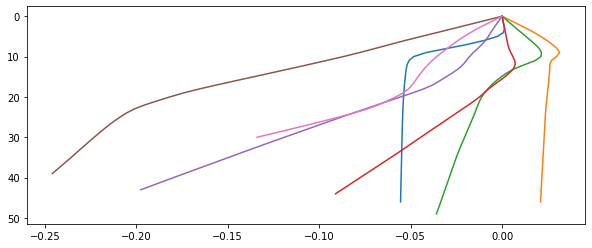

In [232]:
fig, ax = plt.subplots(figsize=(10, 4))
ax = plt.plot(gvel_df,gvel_df.index)
plt.gca().invert_yaxis()

In [252]:
df_SA = gsw.SA_from_SP(df_salt.values,df_salt.index.values.reshape(len(df_salt.index.values),1),dflon.loc[0].values,dflat.loc[0].values)
df_CT = gsw.CT_from_t(df_SA,df_temp.values,df_salt.index.values.reshape(len(df_salt.index.values),1))

gswpan = gsw.geo_strf_dyn_height(df_SA,df_CT,df_salt.index.values.reshape(len(df_salt.index.values),1),axis=0,p_ref=df_salt.dropna(how='any').index.max())

df_salt.dropna(how='any').index

gswvel = gsw.geostrophy.geostrophic_velocity(gswpan,dflon.loc[0].values,dflat.loc[0].values,p=df_salt.dropna(how='any').index.max(),axis=0)



In [253]:
df_SA = gsw.SA_from_SP(df_salt.values,df_salt.index.values.reshape(len(df_salt.index.values),1),dflon.loc[0].values,dflat.loc[0].values)
df_CT = gsw.CT_from_t(df_SA,df_temp.values,df_salt.index.values.reshape(len(df_salt.index.values),1))

gswpan = gsw.geo_strf_dyn_height(df_SA,df_CT,df_salt.index.values.reshape(len(df_salt.index.values),1),axis=0,p_ref=df_salt.dropna(how='any').index.max())

gswvel = gsw.geostrophy.geostrophic_velocity(gswpan,dflon.loc[0].values,dflat.loc[0].values,p=df_salt.dropna(how='any').index.max(),axis=0)


gswvel_df = pd.DataFrame(gswvel[0],columns=geovel_colnames)

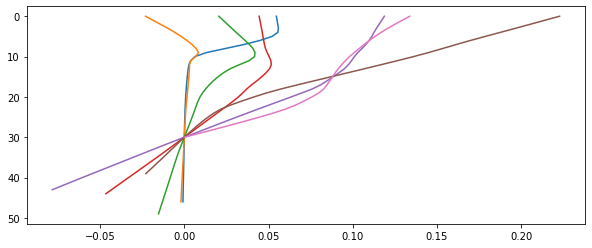

In [254]:
fig, ax = plt.subplots(figsize=(10, 4))
ax = plt.plot(gswvel_df,gswvel_df.index)
plt.gca().invert_yaxis()

In [249]:
alongx=gsw.geostrophy.distance(dflon.loc[0].values,dflat.loc[0].values)
alongx

array([19749.31745922, 19948.32748459, 19759.22439309, 20253.99958812,
       10059.74122833,  9940.22186661, 10028.58022092])

In [250]:
alongx.cumsum()

array([ 19749.31745922,  39697.64494381,  59456.8693369 ,  79710.86892502,
        89770.61015335,  99710.83201996, 109739.41224088])

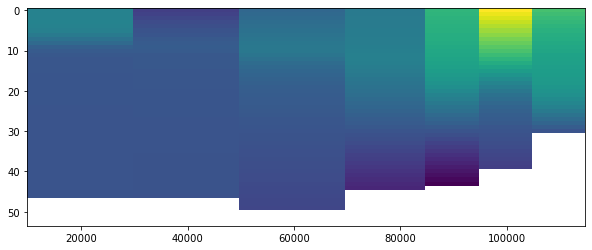

In [251]:
fig, ax = plt.subplots(figsize=(10, 4))
ax = plt.pcolormesh(alongx.cumsum(),gswvel_df.index,gswvel_df,shading='nearest')
plt.gca().invert_yaxis()

In [256]:
gswvel_df.to_csv('aq1201.geovel.csv')
alongx.cumsum()